In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shared drives/SI671_final_project/SI671_final_project/Data_file'

Mounted at /content/drive
/content/drive/Shared drives/SI671_final_project/Data_file


In [ ]:
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.metrics import accuracy_score


from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from wordcloud import WordCloud, STOPWORDS

### Read data from JSON file

In [ ]:
data = pd.read_json('Grocery_and_Gourmet_Food_5.json', lines=True)

In [ ]:
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN,NaN,NaN
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN,NaN,NaN
2,5,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,NaN,NaN,NaN
3,5,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,NaN,NaN,NaN
4,5,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,NaN,NaN,NaN


In [ ]:
data.shape

(1143860, 12)

### Data Preprocessing

In [ ]:
# drop unrelated features
data = data.drop(columns=['image', 'style'], axis=1)

In [ ]:
data.head(2)

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,NaN
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,NaN


In [ ]:
# Get percentage of missing values for each column
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
vote,vote,86.169461
reviewText,reviewText,0.034095
summary,summary,0.019146
reviewerName,reviewerName,0.012064
overall,overall,0.000000
verified,verified,0.000000
reviewTime,reviewTime,0.000000
reviewerID,reviewerID,0.000000
asin,asin,0.000000
unixReviewTime,unixReviewTime,0.000000


In [ ]:
# Drop rows that have missing values on reviewText, summary, reviewerName
data = data.dropna(subset=['reviewText', 'summary', 'reviewerName'])

# From above, we could see that most votes have null values, fill these values with -1
data = data.fillna(-1)

In [ ]:
# Get percentage of missing values for each column
percent_missing = data.isnull().sum() * 100 / len(data)
missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True, ascending=False)
missing_value_df

,column_name,percent_missing
overall,overall,0.0
verified,verified,0.0
reviewTime,reviewTime,0.0
reviewerID,reviewerID,0.0
asin,asin,0.0
reviewerName,reviewerName,0.0
reviewText,reviewText,0.0
summary,summary,0.0
unixReviewTime,unixReviewTime,0.0
vote,vote,0.0


In [ ]:
data.dtypes

overall            int64
verified            bool
reviewTime        object
reviewerID        object
asin              object
reviewerName      object
reviewText        object
summary           object
unixReviewTime     int64
vote              object
dtype: object

In [ ]:
# check the distribution of vote
data["vote"] = data["vote"].apply(lambda x: (x[:1] + x[2:]) if len(str(x)) == 5 else x)
data['vote'] = data['vote'].astype(int)
print(data["vote"].min())
print(data["vote"].max())

-1
2584


In [ ]:
# basket the vote values
data['Upvote'] = pd.cut(data['vote'].astype('int'), bins = [-1, 0, 50, 100, 200, 300, 500, 1000,2000,3000], 
                        labels = ['Empty', '0-50', '50-100', '100-200', '200-300', '300-500', '500-1000', '1000-2000', '2000-3000'], include_lowest = True)

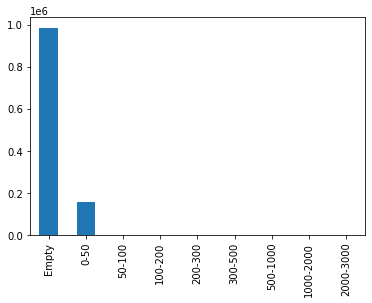

In [ ]:
data['Upvote'].value_counts().plot.bar()

In [ ]:
print(data["overall"].min())
print(data["overall"].max())

1
5


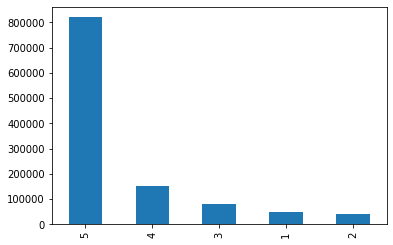

In [ ]:
data['overall'].value_counts().plot.bar()

In [ ]:
# any vote that is greater than 0 will be seen as helpful
data["sentiment"] = data["overall"].apply(
    lambda x: "positive" if x > 3 else "negative")
data["usefulScore"] = data["vote"].apply(
    lambda x: "useful" if x > 0 else "useless")
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,Upvote,sentiment,usefulScore
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,-1,Empty,positive,useless
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,-1,Empty,positive,useless
2,5,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,-1,Empty,positive,useless
3,5,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,-1,Empty,positive,useless
4,5,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,-1,Empty,positive,useless


In [ ]:
print(data[data["vote"] > 0].shape)
print(data[data["vote"] <= 0].shape)

(158154, 14)
(985001, 14)


### Feature extraction from reviewsText

In [ ]:
# Get the english word only
regEX = re.compile('[^a-z]+')
def cleanReviews(text):
  text = text.lower()
  text = regEX.sub(" ", text).strip()
  return text

In [ ]:
data["summary_f"] = data["summary"].apply(cleanReviews)
data.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,Upvote,sentiment,usefulScore,summary_f
0,5,True,"11 19, 2014",A1QVBUH9E1V6I8,4639725183,Jamshed Mathur,No adverse comment.,Five Stars,1416355200,-1,Empty,positive,useless,five stars
1,5,True,"10 13, 2016",A3GEOILWLK86XM,4639725183,itsjustme,Gift for college student.,Great product.,1476316800,-1,Empty,positive,useless,great product
2,5,True,"11 21, 2015",A32RD6L701BIGP,4639725183,Krystal Clifton,"If you like strong tea, this is for you. It mi...",Strong,1448064000,-1,Empty,positive,useless,strong
3,5,True,"08 12, 2015",A2UY1O1FBGKIE6,4639725183,U. Kane,Love the tea. The flavor is way better than th...,Great tea,1439337600,-1,Empty,positive,useless,great tea
4,5,True,"05 28, 2015",A3QHVBQYDV7Z6U,4639725183,The Nana,I have searched everywhere until I browsed Ama...,This is the tea I remembered!,1432771200,-1,Empty,positive,useless,this is the tea i remembered


In [ ]:
# Split the train and test file for ML
train, test = train_test_split(data, test_size = 0.2)
print("%d items in training data, %d in test data" % (len(train), len(test)))

914524 items in training data, 228631 in test data


**Using TfidfTransformer to fit the train and test data**

In [ ]:
countVector = CountVectorizer(min_df=1, ngram_range=(1, 4))
x_train_counts = countVector.fit_transform(train["summary_f"])

In [ ]:
# applying tfidf to term frequency
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_counts)

In [ ]:
x_test_counts = countVector.transform(test["summary_f"])
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

y_train = train["sentiment"]
y_test = test["sentiment"]

prediction = dict()

In [ ]:
stopwords = set(STOPWORDS)

# Set the plot configuration
mpl.rcParams['font.size']=12
mpl.rcParams['savefig.dpi']=100
mpl.rcParams['figure.subplot.bottom']=.1

def show_wordcloud(data, title=None):
  wordcloud = WordCloud(
      background_color="white",
      stopwords=stopwords,
      max_words=200,
      max_font_size=40,
      scale=3,
      random_state=1
  ).generate(str(data))
  fig = plt.figure(1, figsize=(8, 8))
  plt.axis('off')
  if title:
    fig.suptitle(title, fontsize=20)
    fig.subplots_adjust(top=2.3)

  plt.imshow(wordcloud)
  plt.show()

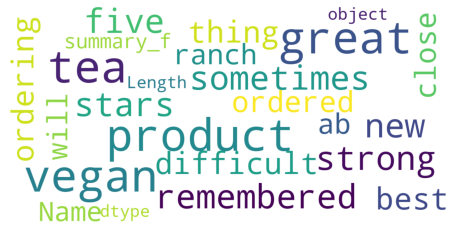

In [ ]:
show_wordcloud(data["summary_f"])

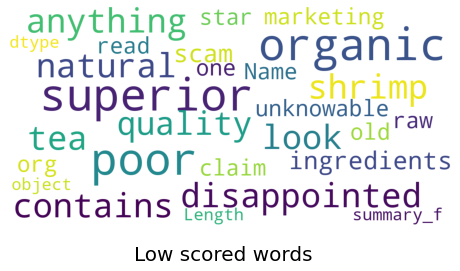

In [ ]:
show_wordcloud(data[data.overall == 1]["summary_f"], title = "Low scored words")

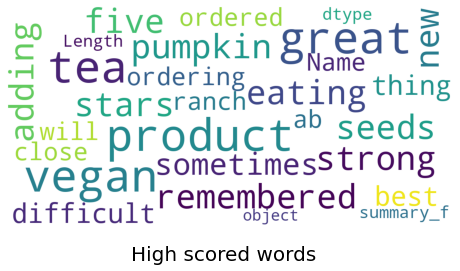

In [ ]:
show_wordcloud(data[data.overall == 5]["summary_f"], title = "High scored words")

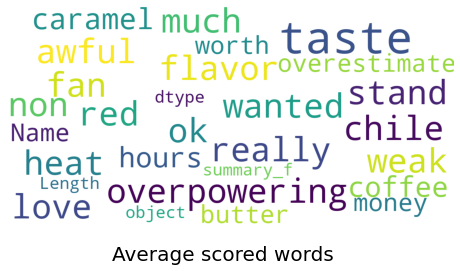

In [ ]:
show_wordcloud(data[data.overall == 2]["summary_f"], title = "Average scored words")

### Multinomial Naive Bayes Learning method

In [ ]:
model = MultinomialNB().fit(x_train_tfidf, y_train)
prediction["Multinomial"] = model.predict(x_test_tfidf)

### Bernoulli Naive Bayes learning method

In [ ]:
model = BernoulliNB().fit(x_train_tfidf, y_train)
prediction["Bernoulli"] = model.predict(x_test_tfidf)

### Logistic Regression learning method

In [ ]:
logreg = LogisticRegression()
logreg_result = logreg.fit(x_train_tfidf, y_train)
prediction["Logistic"] = logreg.predict(x_test_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print(len(prediction['Logistic']))
print(len(prediction['Multinomial']))

228631
228631


### Results

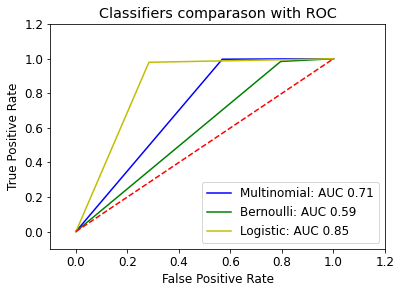

In [ ]:
def formatt(x):
  if x == "negative":
    return 0
  return 1
vfunc = np.vectorize(formatt)

cmp = 0
colors = ['b', 'g', 'y', 'm', 'k']
for model, pre in prediction.items():
  false_pos_rate, true_pos_rate, thresholds = roc_curve(y_test.map(formatt), 
                                                        vfunc(pre))
  roc_auc = auc(false_pos_rate, true_pos_rate)
  plt.plot(false_pos_rate, true_pos_rate, 
           colors[cmp],label='%s: AUC %0.2f'% (model,roc_auc))
  cmp += 1

plt.title("Classifiers comparason with ROC")
plt.legend(loc="lower right")
plt.plot([0,1],[0,1],"r--")
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

### Visualize the accuracy, recall and f1-score for Logistic Regression

In [ ]:
print(metrics.classification_report(y_test, prediction["Logistic"],
                                    target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.86      0.72      0.78     34721
    negative       0.95      0.98      0.96    193910

    accuracy                           0.94    228631
   macro avg       0.91      0.85      0.87    228631
weighted avg       0.94      0.94      0.94    228631



In [ ]:
accuracy_score(y_test, prediction["Logistic"])

0.9394745244520647

<Figure size 432x288 with 0 Axes>

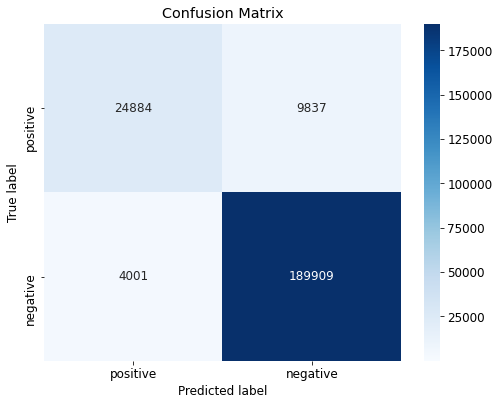

In [ ]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, prediction["Logistic"])
labels = ["positive", "negative"]
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Visualize the accuracy, recall and f1-score for Naive Bayes Berrnoulli

In [ ]:
print(metrics.classification_report(y_test, prediction['Bernoulli'], 
                                    target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.70      0.20      0.32     34721
    negative       0.87      0.98      0.93    193910

    accuracy                           0.87    228631
   macro avg       0.79      0.59      0.62    228631
weighted avg       0.85      0.87      0.83    228631



In [ ]:
accuracy_score(y_test, prediction['Bernoulli'])

0.8657837301153387

<Figure size 432x288 with 0 Axes>

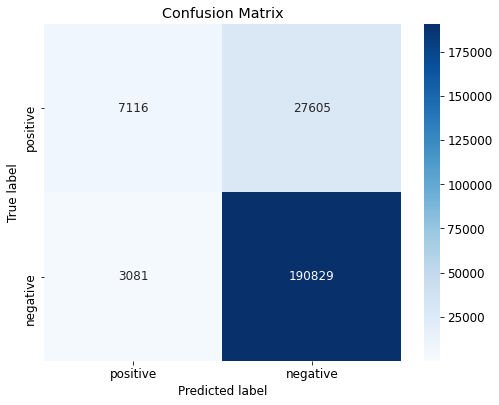

In [ ]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, prediction['Bernoulli'])
labels = ["positive", "negative"]
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Visualize the accuracy, recall and f1-score for Naive Bayes Multinomial

In [ ]:
print(metrics.classification_report(y_test, prediction['Multinomial'], 
                                    target_names = ["positive", "negative"]))

              precision    recall  f1-score   support

    positive       0.96      0.43      0.60     34721
    negative       0.91      1.00      0.95    193910

    accuracy                           0.91    228631
   macro avg       0.94      0.71      0.77    228631
weighted avg       0.92      0.91      0.90    228631



In [ ]:
accuracy_score(y_test, prediction['Multinomial'])

0.9113199872283286

<Figure size 432x288 with 0 Axes>

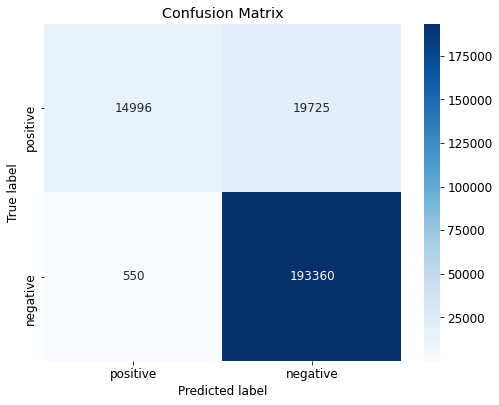

In [ ]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, prediction['Multinomial'])
labels = ["positive", "negative"]
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Displaying words depicting the best and worst features using Logistic Model since it gave the best results

In [ ]:
features = countVector.get_feature_names()
feature_coefs = pd.DataFrame(
    data=list(zip(features, logreg_result.coef_[0])),
    columns = ["feature", "coefficient"]
)

feature_coefs = feature_coefs.sort_values(by="coefficient", ascending=False)

In [ ]:
feature_coefs.head(10)

,feature,coefficient
846227,great,15.532734
217286,best,14.568253
1378360,not bad,13.326454
599783,excellent,11.679535
1379656,not bitter,11.135134
1548451,perfect,10.307389
2326992,wonderful,10.208899
166549,awesome,10.104455
1399006,not too,9.843386
498511,delicious,9.301952


In [ ]:
feature_coefs.tail(10)

,feature,coefficient
519780,didn,-9.290396
2375661,yuck,-9.365434
2103289,three stars,-10.166446
1945645,terrible,-10.342181
970384,horrible,-10.925348
170620,awful,-11.006077
1472563,one star,-11.091099
2179306,two stars,-11.751694
2338542,worst,-13.014682
1376719,not,-14.703824


### Testing the sentiments of few reviews

In [ ]:
def testSentiments(model, testData):
  testCounts = countVector.transform([testData])
  testTfidf = tfidf_transformer.transform(testCounts)
  result = model.predict(testTfidf)[0]
  probability = model.predict_proba(testTfidf)[0]
  print("Sample estimated as %s: negative prob %f, positive prob %f" % 
        (result.upper(), probability[0], probability[1]))
  
testSentiments(logreg, "Heavenly Highway Hymns")
testSentiments(logreg, "Very oily and creamy. Not at all what I expected... ordered this to try to highlight and contour and it just looked awful!!! Plus, took FOREVER to arrive.")
testSentiments(logreg, "Nasty smelling!.")

Sample estimated as POSITIVE: negative prob 0.039709, positive prob 0.960291
Sample estimated as NEGATIVE: negative prob 0.912052, positive prob 0.087948
Sample estimated as NEGATIVE: negative prob 0.903718, positive prob 0.096282
